In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Lambda
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef

# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

2023-05-25 02:18:19.783261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
transactions = pd.read_csv('/Users/user/Documents/datasets/ieee/train_transaction.csv', index_col='TransactionID')
identity = pd.read_csv('/Users/user/Documents/datasets/ieee/train_identity.csv', index_col='TransactionID')
data = transactions.merge(identity, how='left', left_index=True, right_index=True)

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('isFraud', axis=1),
    data['isFraud'],
    test_size=0.2,
    random_state=42
)

In [4]:
# Data preprocessing
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
for col in categorical_cols:
    X_train[col] = X_train[col].fillna('unknown')
    X_test[col] = X_test[col].fillna('unknown')
    le = LabelEncoder()
    le.fit(list(X_train[col].values) + list(X_test[col].values))
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [5]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [6]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [7]:
# Create an autoencoder to generate synthetic fraud data
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Train the autoencoder on normal transactions
X_normal = X_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(X_normal_train, X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, X_normal_test))#100

# Generate synthetic fraud transactions using the trained autoencoder
X_fraud = X_train[y_train == 1]
synthetic_fraud = autoencoder.predict(X_fraud)

#encoded_normal = autoencoder.predict(X)
noise_factor = 0.2
encoded_normal_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)
synthetic_fraud_data = autoencoder.predict(encoded_normal_noisy)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_data)) #synthetic_fraud

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

Epoch 1/100
11401/11401 [==============================] - 22s 2ms/step - loss: 3258.9402 - val_loss: 831.7393
Epoch 2/100
11401/11401 [==============================] - 20s 2ms/step - loss: 194.1641 - val_loss: 22.7226
Epoch 3/100
11401/11401 [==============================] - 20s 2ms/step - loss: 15.8431 - val_loss: 7.7005
Epoch 4/100
11401/11401 [==============================] - 20s 2ms/step - loss: 6.6944 - val_loss: 5.8180
Epoch 5/100
11401/11401 [==============================] - 19s 2ms/step - loss: 5.8907 - val_loss: 4.7777
Epoch 6/100
11401/11401 [==============================] - 20s 2ms/step - loss: 5.2212 - val_loss: 5.2785
Epoch 7/100
11401/11401 [==============================] - 20s 2ms/step - loss: 4.7943 - val_loss: 4.4314
Epoch 8/100
11401/11401 [==============================] - 20s 2ms/step - loss: 4.4836 - val_loss: 3.8357
Epoch 9/100
11401/11401 [==============================] - 20s 2ms/step - loss: 4.8444 - val_loss: 4.3726
Epoch 10/100
11401/11401 [===========

11401/11401 [==============================] - 17s 2ms/step - loss: 2.3918 - val_loss: 2.2666
Epoch 78/100
11401/11401 [==============================] - 17s 2ms/step - loss: 2.2550 - val_loss: 2.1319
Epoch 79/100
11401/11401 [==============================] - 17s 1ms/step - loss: 2.2922 - val_loss: 2.1515
Epoch 80/100
11401/11401 [==============================] - 17s 1ms/step - loss: 2.8930 - val_loss: 2.9553
Epoch 81/100
11401/11401 [==============================] - 17s 2ms/step - loss: 2.7945 - val_loss: 3.4309
Epoch 82/100
11401/11401 [==============================] - 17s 1ms/step - loss: 2.5053 - val_loss: 2.2170
Epoch 83/100
11401/11401 [==============================] - 17s 2ms/step - loss: 2.6018 - val_loss: 3.1869
Epoch 84/100
11401/11401 [==============================] - 17s 2ms/step - loss: 2.5502 - val_loss: 2.8914
Epoch 85/100
11401/11401 [==============================] - 17s 2ms/step - loss: 2.3493 - val_loss: 2.1908
Epoch 86/100
11401/11401 [========================

In [8]:
# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_balanced, y_balanced)

In [9]:
# Train a random forest classifier on the resampled training data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [10]:
# Make predictions on the testing data
y_pred = model.predict(X_test.fillna(0))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [11]:
# Calculate the accuracy and other performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall

Accuracy: 0.9791292715142074
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.91      0.47      0.62      4242

    accuracy                           0.98    118108
   macro avg       0.94      0.73      0.80    118108
weighted avg       0.98      0.98      0.98    118108

Confusion matrix:
[[113669    197]
 [  2268   1974]]


In [12]:
#predict the class probabilities
y_pred_proba = model.predict_proba(X_test.fillna(0))[:, 1]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [13]:
#calculate the AUC value
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred_proba)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

F1-score:  0.6156245127085608
Precision:  0.9092584062643942
Recall:  0.46534653465346537
Specificity:  0.9982698961937716
Sensitivity:  0.46534653465346537
AUC:  0.9314520375170221


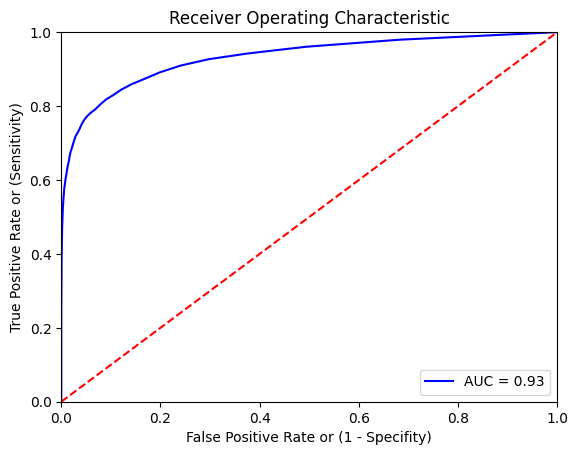

In [14]:
# calculate & plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1],'r--')#plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

Accuracy: 0.979129


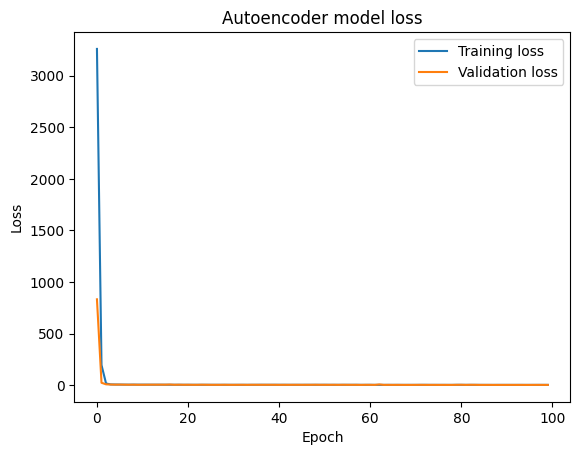

In [16]:
# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.6422442766049113


In [18]:
df = data

In [19]:
df

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
##

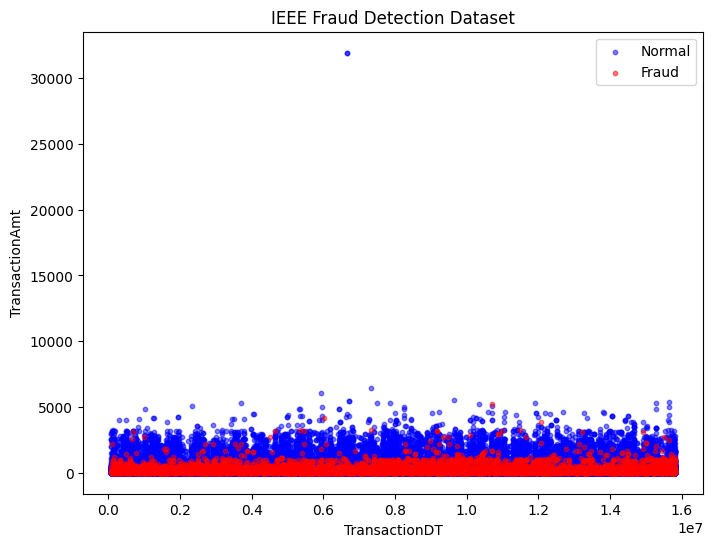

In [21]:
# Separate the normal and fraud data
normal_data = df[df['isFraud'] == 0]
fraud_data = df[df['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("IEEE Fraud Detection Dataset")
plt.scatter(normal_data['TransactionDT'], normal_data['TransactionAmt'], c="blue", label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['TransactionDT'], fraud_data['TransactionAmt'], c="red", label='Fraud', s=10, alpha=0.5)
plt.xlabel("TransactionDT")
plt.ylabel("TransactionAmt")
plt.legend()
plt.show()

In [22]:
df1 = np.column_stack([X_train_resampled, y_train_resampled])
df2 = np.column_stack([X_test, y_test])

In [23]:
df3 = np.vstack([df1, df2])

In [24]:
df.columns.tolist()

['isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67

In [25]:
df.shape

(590540, 433)

In [26]:
df4 = pd.DataFrame(df3, columns =['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'isFraud'])

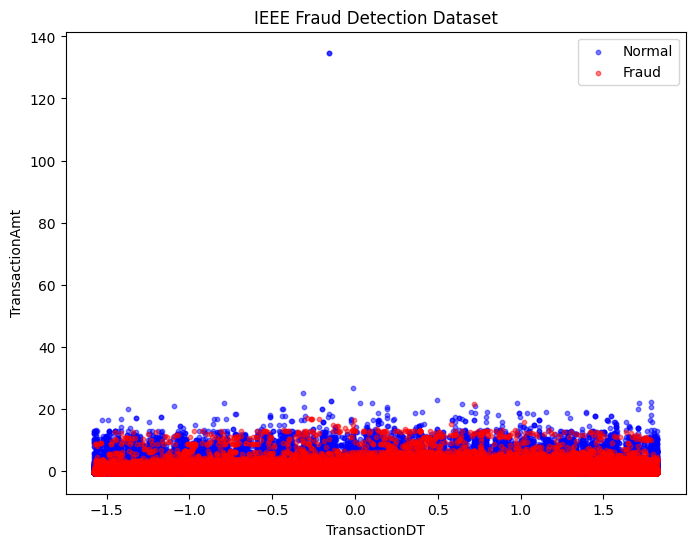

In [27]:
# Separate the normal and fraud data
normal_data = df4[df4['isFraud'] == 0]
fraud_data = df4[df4['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("IEEE Fraud Detection Dataset")
plt.scatter(normal_data['TransactionDT'], normal_data['TransactionAmt'], c="blue", label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['TransactionDT'], fraud_data['TransactionAmt'], c="red", label='Fraud', s=10, alpha=0.5)
plt.xlabel("TransactionDT")
plt.ylabel("TransactionAmt")
plt.legend()
plt.show()

In [28]:
df4

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,-1.558637,-0.322223,4.0,-1.003053,-0.180659,-0.281991,4.0,0.647908,2.0,0.236804,...,0.000000,260.0,4.0,2.0,2.0,2.0,2.0,2.0,1774.0,0.0
1,-0.664988,-0.473144,0.0,-1.231887,-0.421547,2.803900,4.0,0.647908,1.0,0.000000,...,0.000000,260.0,4.0,0.0,0.0,1.0,0.0,0.0,1774.0,0.0
2,-0.247521,-0.419880,4.0,0.546113,-0.599044,-0.281991,4.0,-0.807802,2.0,1.818616,...,0.000000,260.0,4.0,2.0,2.0,2.0,2.0,2.0,1774.0,0.0
3,-1.488856,-0.148516,2.0,-0.792592,1.397793,-0.281991,4.0,0.647908,1.0,-1.620107,...,-0.671576,98.0,3.0,1.0,0.0,1.0,0.0,0.0,1598.0,0.0
4,-1.352975,-0.254435,1.0,1.260171,0.960391,-0.281991,2.0,-2.360559,1.0,0.335053,...,1.468764,164.0,3.0,1.0,0.0,1.0,1.0,1.0,1297.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030125,0.420403,-0.093439,4.0,-1.563603,1.220296,-0.281991,4.0,0.647908,2.0,-0.853763,...,0.000000,260.0,4.0,2.0,2.0,2.0,2.0,2.0,1774.0,0.0
1030126,-0.331108,-0.076492,4.0,-0.232451,1.220296,-0.281991,4.0,0.647908,2.0,-0.588490,...,0.000000,260.0,4.0,2.0,2.0,2.0,2.0,2.0,1774.0,0.0
1030127,0.891768,-0.320049,0.0,1.272623,-1.004751,2.803900,4.0,-1.487133,2.0,0.000000,...,0.000000,260.0,4.0,0.0,0.0,1.0,0.0,1.0,205.0,0.0
1030128,1.418394,-0.480762,0.0,1.221386,1.156905,2.803900,4.0,-1.487133,2.0,0.000000,...,0.000000,260.0,4.0,0.0,0.0,1.0,0.0,1.0,1189.0,0.0
